In [1]:
import numpy as np
np.random.seed(1001)

import pickle
import os
import shutil

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold, train_test_split
import sklearn
import dask.dataframe as dd
from dask import array

import librosa
import IPython.display as ipd  # To play sound in the notebook
import librosa.display

import keras
from keras.layers import Conv1D, Dropout, Dense, MaxPooling1D, Flatten, Conv2D, MaxPooling2D
from keras import Sequential

%matplotlib inline
matplotlib.style.use('ggplot')

import dask
from dask.distributed import Client, wait, progress
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
client = Client()

In [3]:
client

Client Scheduler: tcp://127.0.0.1:50066 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 16.90 GB


In [4]:
metadata = pd.read_csv("file_metadata.csv", index_col=0)

# Features

In [6]:
y, sr = librosa.load(metadata["filepath"].iloc[0])

In [7]:
y

array([ 1.5591205e-07, -1.5845627e-07,  1.5362870e-07, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)

In [8]:
D = librosa.stft(y, n_fft=512)

spec = librosa.amplitude_to_db(D,ref=np.max)

c:\users\chris\appdata\local\programs\python\python35\lib\site-packages\librosa\core\spectrum.py:960: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


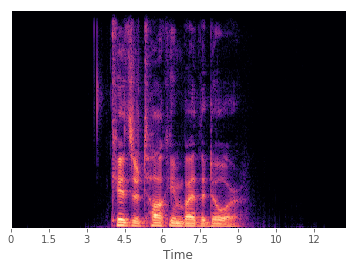

In [13]:
librosa.display.specshow(spec, x_axis='time')

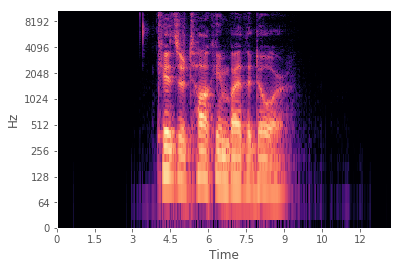

In [12]:
librosa.display.specshow(spec, y_axis='log', x_axis='time')

In [6]:
spec.shape

NameError: name 'spec' is not defined

In [6]:
def get_stft_2d(y, sr, hop_length=32):
    D = librosa.stft(y, hop_length=hop_length, n_fft=1024)
    spec = librosa.amplitude_to_db(D,ref=np.max)
    df = pd.DataFrame(spec / 80)
    return spec

In [7]:
def get_length_in_seconds(y,sr):
    return len(y)/sr

def create_samples_from_fn(idx, fn, return_data=False, save_data=True, stft_fea=False):
    """
    Also trims silence from a file
    """
    desired_sr = 22050
    try:
        # Load, resample if needed
        y, sr = librosa.load(fn)
    except:
        return None
    if sr != desired_sr:
        y = librosa.core.resample(y, sr, desired_sr)
        sr = desired_sr

    # Standard scaling
    standardScaler = StandardScaler()    
    y = standardScaler.fit_transform(y.reshape(-1, 1)).reshape(1, -1)[0]

    length = get_length_in_seconds(y, sr)

    #ax.plot(y, alpha=0.3)
    #print(f"{np.round(length, 4)}")
    # Trim silence
    y_trimmed = librosa.effects.trim(y, top_db=12.5)[0]
    length_trimmed = get_length_in_seconds(y_trimmed, sr)
    #print(f"{np.round(length_trimmed, 4)}")
    #plt.plot(y_trimmed, alpha=0.5)

    # Split into chunks
    chunk_len = int(sr / 2) # .5 seconds
    end = len(y_trimmed) - (len(y_trimmed) % chunk_len)
    n_chunks = int(end / chunk_len)
    if n_chunks == 0:
        return None
    y_trimmed_chunks = np.split(y_trimmed[:end], n_chunks)
    
    #print([x.shape for x in y_trimmed_chunks])

    # TODO: Engineer some damn features!
    
    y_trimmed_chunks = [x for x in y_trimmed_chunks]
    
    if stft_fea:
        y_feature_chunks = [get_stft_2d(ch, desired_sr) for ch in y_trimmed_chunks]
    else:
        y_feature_chunks = [get_ts_features(ch, desired_sr).values for ch in y_trimmed_chunks]  
    
    for i in range(len(y_feature_chunks)):
        res = pd.DataFrame(y_feature_chunks[i])
        res.columns = res.columns.astype(str)
        res["sample"]="{}-{}".format(idx, i) # Store the
        if save_data:
            if stft_fea:
                res.to_parquet("../data/listenr-ml/preprocessed_3/{}-{}.parquet".format(idx, i))
            else:
                res.to_parquet("../data/listenr-ml/preprocessed_2/{}-{}.parquet".format(idx, i))
    if return_data:
        return res

In [8]:
def establish_data(metadata):
    """
    Save all preprocessed (and eventually feature engineered samples)
    """
    n = len(metadata)
    
    futures = []

    for idx, data in metadata.iterrows():
        futures.append(client.submit(create_samples_from_fn, idx, data["filepath"], return_data=False, save_data=True, stft_fea=True,
                                    key=idx))
    return futures
    

In [34]:
# futures = establish_data(metadata)

In [19]:
# def load_one(fn):
#     res = pd.read_parquet("../data/listenr-ml/preprocessed_2/{}".format(fn))
#     return res
# res = load_one("0-0.parquet")

In [53]:
import gc

def get_scaler(client, metadata):
    """
    Load all samples and train a standardscaler
    """
    folder = "../data/listenr-ml/preprocessed_3/"
    basenames = os.listdir(folder)
    fns = ["../data/listenr-ml/preprocessed_3/{}".format(x) for x in basenames]
    
    sScaler = StandardScaler()

    # k is chunk size, i is iterator
    k = 500
    i = 0
    
    while (i*k) < len(fns):
        
        start = i*k
        end = min((i+1)*k, len(fns))
        
        print(start,end)
        i+= 1
        futures = [client.submit(pd.read_parquet, x) for x in fns[start:end]]
        x = pd.concat(client.gather(futures))
        sScaler.partial_fit(x[x.columns[:-1]])
    
    with open("2DScaler.p", "wb") as fp:
        pickle.dump(sScaler, fp)
        
    return sScaler
    
    # First, train a standard scaler on all elements
    df = dd.read_parquet("{}*.parquet".format(folder)).compute()
    
    gc.collect()
    client.restart()

    print(df.shape)
    print("scaling")
    # Transform to standard scale, then ignore the sample name column
    sScaler.fit(df[df.columns[:-1]])
    
    with open("2DScaler.p", "wb") as fp:
        pickle.dump(sScaler, fp)
    
    return sScaler

In [54]:
scaler = get_scaler(client, metadata)

0 500


c:\users\chris\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.


500 1000


c:\users\chris\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.


1000 1500


c:\users\chris\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.


1500 2000


c:\users\chris\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.


2000 2500


c:\users\chris\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.


2500 3000


c:\users\chris\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.


3000 3500


c:\users\chris\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.


3500 4000


c:\users\chris\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.


4000 4500


c:\users\chris\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.


4500 4686


c:\users\chris\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.


'2. Data preprocessing 1D.ipynb'

In [94]:
def scale_a_sample(fn, scaler):
    df = pd.read_parquet(fn)
    #Transform to standard scale, then ignore the sample name column
    X = pd.DataFrame(scaler.transform(df[df.columns[:-1]]))
    X.columns = [str(x) for x in X.columns]
    b = os.path.basename(fn)
    X.to_parquet("../data/listenr-ml/preprocessed_3_scaled/{}".format(b))
    
def scale_all_samples(scaler):
    """
    Load all samples into keras-digestible format
    """
    folder = "../data/listenr-ml/preprocessed_3/"
    
    basenames = os.listdir(folder)
        
    fns = ["../data/listenr-ml/preprocessed_3/{}".format(x) for x in basenames]
    # Get the original sample's metada for each of these chunks
    indices = [int(x.split("-")[0]) for x in basenames]
    futures = []
    for fn in fns:
        futures.append(client.submit(scale_a_sample, fn, scaler))
    return futures
    # Transform to standard scale, then ignore the sample name column
    #     df[df.columns[:-1]] = sScaler.fit_transform(df[df.columns[:-1]])

with open("2DScaler.p", "rb") as fp:
    scaler = pickle.load(fp)
    
ff = scale_all_samples(scaler)

In [123]:
def get_input(path):
    return pd.read_parquet(path).values.reshape((513, 345, 1))
    
def get_output(path, metadata):
    sample = int(os.path.basename(path).split("-")[0])
    return metadata[metadata.columns[-6:]].loc[sample].values

def batch_gen(files, metadata, batch_size = 32):
  
    while True:
        # Select files (paths/indices) for the batch
        batch_paths = np.random.choice(a = files, 
                                     size = batch_size)
        batch_input = []
        batch_output = []

        # Read in each input, perform preprocessing and get labels
        for input_path in batch_paths:

            input_ = get_input(input_path )
            output = get_output(input_path,metadata)

            batch_input += [input_]
            batch_output += [output]

        # Return a tuple of (input,output) to feed the network

        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)

        yield(batch_x, batch_y)
        
folder = "../data/listenr-ml/preprocessed_3_scaled/"
sample_fns = ["{}{}".format(folder, x) for x in os.listdir(folder)]

train_fns = np.random.choice(sample_fns, 4000, replace=False)
test_fns = list(set(sample_fns) - set(train_fns))
val_fns = np.random.choice(train_fns, 400, replace=False)
train_fns = list(set(train_fns) - set(val_fns))
test_fn_index = [int(os.path.basename(x).split("-")[0]) for x in test_fns]
test_class = metadata.loc[test_fn_index]["emo"]

# G-G-G-GRID SEARCH

In [ ]:
def build_2D_model_test(input_shape, n_classes, dropout, 
                        base_dense, n_filters, n_conv, filter_size=10, extra_dense=False):
    model = Sequential()
    
    for i in range(n_conv):
        model.add(Conv2D(n_filters, (filter_size, int(filter_size * 2 / 3)),
                                padding='valid',
                                input_shape=input_shape,
                                activation="relu"))
        model.add(MaxPooling2D(padding="same", pool_size=(filter_size)))
        model.add(Dropout(dropout))
        
        filter_size -= 1
    
    model.add(Flatten())
    model.add(Dense(base_dense, activation="relu"))
    model.add(Dropout(dropout))    

    if extra_dense:
        model.add(Dense(int(base_dense / 2), activation="relu"))
        model.add(Dropout(dropout))    

    model.add(Dense(n_classes, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['acc'])
    
    return model

from keras import backend as K
import tensorflow as tf
import gc

# Parameter space
dropout_rates = [0.1, 0.3, 0.5]
n_conv_layers = [2,3,4]
base_dense_size = [64, 128]
n_filterses = [32 ,64, 128]
extra_denses = [True, False]

idx = 0
for dropout in dropout_rates:
    for n_conv in n_conv_layers:
        for base_dense in base_dense_size:
            for n_filters in n_filterses:
                for extra_dense in extra_denses:
                    print(dropout, n_conv, base_dense, n_filters, extra_dense)

                    with tf.Graph().as_default():
                        with tf.Session() as sess:
                            # Single row df for each result, intended to be dask-read into a large df
                            df = pd.DataFrame(columns=["dropout", "n_conv", "base_dense", "n_filters", "loss", "acc"])
                            vals = [dropout, n_conv, base_dense, n_filters]
                            
                            # Build this model
                            md = build_2D_model_test((513,345, 1), 6,  
                                                     dropout=dropout, 
                                                     n_conv=n_conv,
                                                     base_dense=base_dense,
                                                     n_filters=n_filters,
                                                     extra_dense=extra_dense)
                            
                            # Create generators for data streams
                            train_gen = batch_gen(train_fns, metadata)
                            val_gen = batch_gen(val_fns, metadata)
                            test_gen = batch_gen(test_fns, metadata)
                            
                            md.fit_generator(train_gen, 
                                             steps_per_epoch=len(train_fns)// batch_size,
                                             validation_data=val_gen, 
                                             validation_steps=len(train_fns)// batch_size,
                                             epochs = 50, 
                                             verbose=2, 
                                             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 min_delta=0,
                                                 patience=4,
                                                 verbose=1, mode='auto', restore_best_weights=True)])
                            
                            # Store the scores for each mini test batch
                            sub_scores = []
                            sub_losses = []

                            # Score the model by predicting the test set 40 at a time
                            for test_split in [test_fns[x*40:(x+1)*40] for x in range(len(test_fns)//40)]:
                                X_test = np.array([get_input(t) for t in test_split])
                                preds = md.predict(X_test)

                                test_fn_index = [int(os.path.basename(x).split("-")[0]) for x in test_split]
                                test_class = metadata.loc[test_fn_index]["emo"]
                                base_class = test_class.reset_index()["emo"]
                                preds_no_index = pd.DataFrame(preds).idxmax(axis=1)
                                correct = preds_no_index == base_class
                                accuracy = correct.astype(bool).mean()
                                
                                sub_scores.append(accuracy)
                                sub_losses.append(((pd.get_dummies(base_class) - preds) ** 2).sum(axis=1).mean())

                            # Overall score for this model is the mean of each sub-batch's score
                            score = np.mean(sub_scores)
                            loss = np.mean(sub_losses)
                            
                            # Memory management
                            gc.collect()
                            
                            vals.extend([loss, accuracy])

                            df.loc[idx] = vals
                            df.to_parquet("res/{}-{}-{}-{}-{}.parquet".format(dropout, n_conv, base_dense, n_filters, extra_dense))
                            print(idx, score, loss)
                            idx += 1

0.1 2 64 32 True
Epoch 1/50
 - 118s - loss: 1.7714 - acc: 0.2112 - val_loss: 1.7677 - val_acc: 0.2246
Epoch 2/50
 - 112s - loss: 1.7325 - acc: 0.2600 - val_loss: 1.7275 - val_acc: 0.2854
Epoch 3/50
